## Download Data from Kaggle

In [1]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

W0818 14:47:42.821612 140653475465088 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0818 14:47:43.973566 140653475465088 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py

Download 100%.


In [0]:
!mkdir ~/.kaggle

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c ml-marathon-final

  0% 0.00/9.12k [00:00<?, ?B/s]
100% 9.12k/9.12k [00:00<00:00, 8.10MB/s]
 80% 63.0M/78.3M [00:00<00:00, 96.4MB/s]
100% 78.3M/78.3M [00:00<00:00, 133MB/s] 


In [5]:
!ls

adc.json  data.zip  sample_data  sample_submission.csv


In [0]:
import zipfile

zip_ref = zipfile.ZipFile('data.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [7]:
!ls

adc.json  data.zip  kaggle_dogcat  sample_data	sample_submission.csv


#Preprocess Images

In [8]:
import numpy as np 
import pandas as pd 
import os
train_dir = "./kaggle_dogcat/train/"
test_dir =  "./kaggle_dogcat/test/"

# Load all the filenames (Actually we can use "flow_from_directory" function
# from ImageDataGenerator to load the image, in case the momory is tight)
train_dog_fns = os.listdir(train_dir + "dogs/")
train_cat_fns = os.listdir(train_dir + "cats/")
test_fns = os.listdir(test_dir)

#############################################################
#############################################################
#Dont forget to sort the file name for matching submission ID
test_fns.sort()
#############################################################
############################################################

# Check the legnth of all data first
print(f"dog images in training set : {len(train_dog_fns)}")
print(f"cat images in training set : {len(train_cat_fns)}")
print(f"total images in test set : {len(test_fns)}")

dog images in training set : 2000
cat images in training set : 2000
total images in test set : 400


In [0]:
target_size = (32,32,3)

In [10]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

#This two array is for channel-base mean subtraction preprocessing
#although my score had became worse after using it. 
#pre-calculated mean value of each channel of training  dataset
#Pre-calculate std values of each channel of training dataset
train_mean = np.array([0.4914, 0.458, 0.4193], dtype = 'float64')
train_std = np.array([0.2591,0.2524,0.25511] , dtype = 'float64')

def load_target_img(grayscale = False, color_mode = 'rgb'
                    , target_size = target_size, interpolation = 'bicubic'):
    '''
    grayscale : loading image with color type or grayscale type
    color_mode : loading image with rgb color space and the channels are (r,g,b)
    target_size :Image will be rescale/resize to the target size when loading
    interpolation : the interpolation algorithm for rescaling/resizing the image, nearest is the most simplest and fastest one 
    '''
    def f(path):
        return load_img(path = path, grayscale = grayscale, color_mode = color_mode,
                              target_size = target_size, interpolation=interpolation)
    return f

# I created an image generator to generate the image in batch size
# In case the momery is not enough

def image_generator(load_dir, dog_fns, cat_fns, batch_size = 32):
    '''
    load_dir : data loading path
    dog_fns : filenames of dog picture
    cat_fns : filenames of cat picture
    batch_size : how many data we package as a batch
    '''
    dog_load_dir = load_dir + "dogs/"
    cat_load_dir = load_dir + "cats/"
    data_batch = []
    label_batch = []
    
    while True:
        for idx in range(min(len(dog_fns),len(cat_fns))):
            
            # We should check the file is .jpg format or not
            if ".jpg" in dog_fns[idx] and ".jpg" in cat_fns[idx]:
                data_batch.append( np.asarray(load_target_img()(dog_load_dir + dog_fns[idx])) ) 
                label_batch.append([1,0]) # setting dog label to 0
                data_batch.append( np.asarray(load_target_img()(cat_load_dir + cat_fns[idx])) )
                label_batch.append([0,1]) # setting cat label to 1
                    
                # When the batch collecting is reach to batch_size
                # The data is ready to shipping out
                # yield can keep the status of your function 
                if len(data_batch) >= batch_size :
                    yield np.stack(data_batch), np.stack(label_batch)
                    data_batch = []
                    label_batch = []
                
def image_augmentation_generator(input_gen, image_gen):
    '''
    input_gen : input image generator, it will generate a batch of data a time
    image_gen : ImageDataGenerator from keras
    '''
    for data, label in input_gen:
        
        data,label = shuffle(data, label, random_state = np.random.choice(2019,1)[0])
        
        #We need to recover the original depth of image before augmentation
        #Since the augmentation process is based on normal image depth(8 bits, 0-255)
        x = image_gen.flow(data, batch_size = data.shape[0], shuffle = False)
        y = label
        
        #Dont forget to normalize the image back after done aumentation processing
        yield next(x), y
        

        
#Since the test dataset is small (only 400 pictures), so I decided to read all of them into RAM
test_x = []
for fn in test_fns:
    if ".jpg" in fn:
        test_x.append(np.asarray(load_target_img()(test_dir + fn)))

#dont forget to normalize the data
test_x = np.asarray(test_x, dtype = 'float64') / 255.0
test_x.shape

Using TensorFlow backend.


(400, 32, 32, 3)

In [0]:
#split the training dataset and validation dataset
train_dog_fns, valid_dog_fns = train_dog_fns[:1800], train_dog_fns[1800:]
train_cat_fns, valid_cat_fns = train_cat_fns[:1800], train_cat_fns[1800:]

In [0]:
batch_size = 64

In [0]:
train_input_gen = image_generator(train_dir, train_dog_fns, train_cat_fns,batch_size)
valid_input_gen = image_generator(train_dir, valid_dog_fns, valid_cat_fns,batch_size)

train_image_gen = ImageDataGenerator(
            rotation_range = 40,
            shear_range = 0.2,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            rescale = 1.0/255.0
            )

valid_image_gen = ImageDataGenerator( rescale = 1.0/255.0 )

train_aug_gen = image_augmentation_generator(train_input_gen, train_image_gen)
valid_aug_gen = image_augmentation_generator(valid_input_gen, valid_image_gen)

batch data shape : (64, 32, 32, 3)
batch label shape : (64, 2)


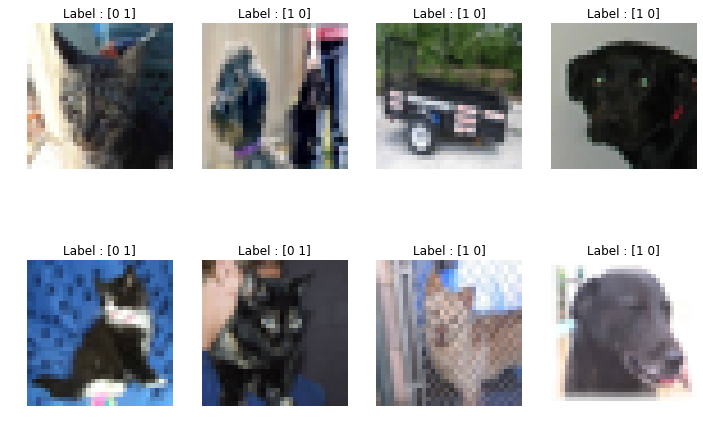

In [14]:
#Use next to get one batch of data and label
batch_data, batch_label = next(valid_aug_gen)
print(f"batch data shape : {batch_data.shape}")
print(f"batch label shape : {batch_label.shape}")

plt.figure(figsize = (12,8))
nrow = 2
ncol = 4

for i in range(nrow*ncol):
    img = batch_data[i]
    label = batch_label[i]
    plt.subplot(nrow,ncol,i+1)
    plt.title(f"Label : {label}")
    plt.axis('off')
    plt.imshow(img)
plt.show()

## Build CNN Model

In [0]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping


In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

weight_saving_path = "kochifinal_exam.hdf5"

#ModelCheckpoint will keep monitor your monitor item, and it will save the weight automatically
#when the monitor item is imporved
checkpoint = ModelCheckpoint(weight_saving_path, monitor = "val_loss", verbose = 1,
                            save_best_only = True, mode = "min")

#ReduceLROnPlateau will reduce your learning rate if the monitor item was not improve in patience times.
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", verbose = 1, mode = "min", patience = 5,
                             factor = 0.5, min_lr = 1e-8)

#EarlyStopping will stop the training if the monitor item was not improve in patience times.
ES = EarlyStopping(monitor = "val_loss", patience = 20, mode = "min", verbose = 1)

training_callbacks = [checkpoint, ES]

In [0]:
def build_CNN(input_shape):
  
  input_layer = keras.layers.Input(test_x.shape[1:])
  
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same')(input_layer)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  
  x = Conv2D(filters = 128, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 128, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  
  x = Flatten()(x)
  
  x = Dense(units = 1024)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  
  
  x = Dense(units = 512)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  
  
  output_layer = Dense(units = 2, activation = "softmax")(x)
  
  model = keras.models.Model( inputs = [input_layer], outputs = [output_layer])
  
  return model
  
  

In [0]:
epochs = 100

In [43]:
cnn_model = build_CNN(target_size)
cnn_model.summary()     


optimizer = keras.optimizers.Adam(lr = 1e-4, decay = 1e-6)
cnn_model.compile(loss = "categorical_crossentropy", metrics = ['accuracy'], optimizer = optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_43 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_43 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_44 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_44 (Activation)   (None, 32, 32, 32)        0         
__________

In [44]:
history = cnn_model.fit_generator(train_aug_gen, epochs = epochs, verbose =1, validation_data = valid_aug_gen , validation_steps = (len(valid_dog_fns) + len(valid_cat_fns))//batch_size,
                                steps_per_epoch = (len(train_dog_fns)+len(train_cat_fns))//batch_size, callbacks = training_callbacks)

Epoch 1/100
56/56 [==============================] - 55s 983ms/step - loss: 0.8483 - acc: 0.5363 - val_loss: 0.7145 - val_acc: 0.5651

Epoch 00001: val_loss improved from inf to 0.71455, saving model to kochifinal_exam.hdf5
Epoch 2/100
56/56 [==============================] - 49s 875ms/step - loss: 0.8084 - acc: 0.5756 - val_loss: 0.7076 - val_acc: 0.5755

Epoch 00002: val_loss improved from 0.71455 to 0.70757, saving model to kochifinal_exam.hdf5
Epoch 3/100
56/56 [==============================] - 49s 876ms/step - loss: 0.7683 - acc: 0.5857 - val_loss: 0.6854 - val_acc: 0.6094

Epoch 00003: val_loss improved from 0.70757 to 0.68543, saving model to kochifinal_exam.hdf5
Epoch 4/100
56/56 [==============================] - 49s 878ms/step - loss: 0.7451 - acc: 0.5974 - val_loss: 0.6672 - val_acc: 0.6276

Epoch 00004: val_loss improved from 0.68543 to 0.66715, saving model to kochifinal_exam.hdf5
Epoch 5/100
56/56 [==============================] - 49s 881ms/step - loss: 0.7438 - acc: 0.

AttributeError: ignored

In [0]:
cnn_model.load_weights('kochifinal_exam.hdf5')

In [46]:
plt.figure(figsize = (8,6))
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'valid_loss')
plt.title("Loss of model on Dogs and Cats classification")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(history.history['acc'], label = 'train_acc')
plt.plot(history.history['val_acc'], label = 'valid_acc')
plt.title("Accuracy of model on Dogs and Cats classification")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

NameError: ignored

<Figure size 576x432 with 0 Axes>

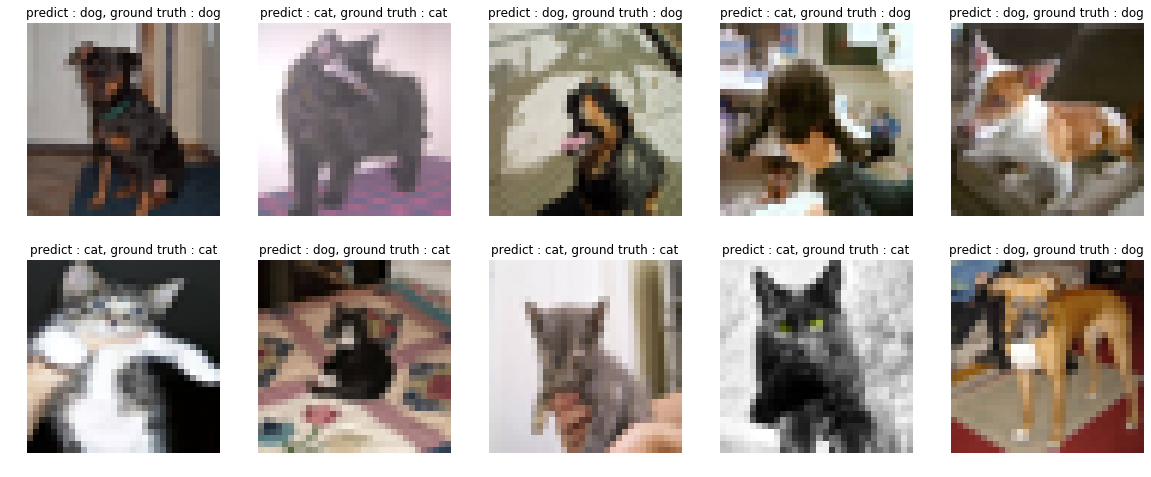

In [48]:
valid_data,valid_label =  next(valid_aug_gen)

def get_label_name(prediction):
    return "dog" if prediction < 0.5 else "cat"

plt.figure(figsize = (20,8))
nrow = 2
ncol = 5

for i,(img, label) in enumerate(zip(valid_data[:10], valid_label[:10])):
    
    predict_result = cnn_model.predict(np.expand_dims(img, axis = 0))[:,1]
    predict_result = get_label_name(predict_result[0])
    ground_truth = get_label_name(label[1])
    
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(img)
    plt.title(f"predict : {predict_result}, ground truth : {ground_truth}")
    plt.axis("off")

plt.show()

In [0]:
submission = pd.read_csv('sample_submission.csv')
submission['Predicted'] = cnn_model.predict(test_x)[:,1] 
submission.to_csv("submission_v6.csv",header = ["ID", "Predicted"], index = False)

In [0]:
from google.colab import files

files.download('submission_v6.csv')